# ECoG Foundation Model Training
This is meant to be a tutorial notebook which is capable of running model training with a free to use colab notebooks. Feel free to change this as you see fit for your experiments.

In [34]:
# The local path to the github repo. Must be accessible from this notebook.
# For compute cluster or local machine.
path_to_github_repo = '../'

# For Colab.
# path_to_github_repo = 'ECoG-foundation-model/'

In [35]:
# Add import for ECoG code.
import sys
import os
import numpy as np
import torch
import torch.nn as nn
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import mne
import time
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.append(os.path.join(path_to_github_repo, 'ECoG_MAE'))

# Other imports
from dataclasses import dataclass

from config import VideoMAEExperimentConfig, VideoMAETaskConfig, ViTConfig, TrainerConfig, ECoGDataConfig, write_config_file
import math
from ecog_setup import system_setup, model_setup
from loader import dl_setup
import constants
from train import train_model
import utils
from mae_st_util.models_mae import MaskedAutoencoderViT
from plot import plot_multi_band_reconstruction
from mask import get_padding_mask

## Foundation Model Pre-Training - Masked Data Reconstruction

To motivate this next step a bit let's look at a previous project from the Hasson Lab.

On top of other topics the paper ["Shared computational principles for language processing in humans and deep language models"](https://hassonlab.princeton.edu/sites/g/files/toruqf3591/files/documents/Goldstein_et_al_NN_2022.pdf) studied encoding and decoding performance between GPT-2 embeddings and corresponding neural signals as a function of when the neural data occured relative to the word onset. There they simply averaged 200 ms windows of neural data which was then fed either as an input or target variable of the model as a way of summarizing some of the relevant information in the signal. Here though we want to try to piggy back off of this and recent advancements in machine learning by seeing whether we can improve performance on encoding and decoding by summarizing the neural data using a low-dimensional embedding generated by a deep network rather than a simple average.

To do this we are currently trying to use a technique common in language, image, and even video modelling by using a [masked auto-encoder](https://arxiv.org/pdf/2111.06377). In particular we are borrowing the model from Meta's [MAE-ST Paper](https://arxiv.org/pdf/2205.09113) paper which learns useful embeddings of video data using transformers. Applying what we saw in the "Data" section above, we are treating our 8x8 grid electrodes as a video where we mask out patches of that video randomly and then train the model to reconstruct them. In short what we do is:

1. Mask data.
2. Pass unmasked data through encoder (this gives us our lower dimensional embedding)
3. Pass low d embeddings and mask tokens through decoder and score the model on how well it performs.
4. Use gradient descent to train the model weights.

And that's it! The trick then is to actually make the model learn well which is more of an engineering problem relating to the actual architecture and the hyperparameters of your model. I present some ideas on how you could experiment with these things below during the hackathon.

One key to remember though is that the important bit of this is the downstream task such as language encoding. Our end-goal is to study whether or not training a model on neural data with no explicit tie to language would somehow encode useful information about language.

If this part is overwhelming or you don't have experience with deep learning don't worry! You can still run the code or just use one of our pre-trained models for something else although we're still trying to improve performance. There's also more ideas for projects below that are not based on machine learning and are more to try and get an intuitive understanding of the dataset. See the encoding and decoding sections below.

If you are unfamiliar with deep learning in general and want to deep-dive into the topic I would recommend going through this course from Andrej Karpathy (co-founder of Open AI): [nn0tohero](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ). This course gives very practical advice for deep learning as well as giving a lot of hands-on intuition on how these models work and how to approach using them for modelling tasks. Building GPT/Transformers from scratch in one of the later lessons is a great way to actually understand how they work and get a sense of their limitations.

If you just want a quick refresher on how transformers work this video series is great: [https://www.youtube.com/watch?v=yGTUuEx3GkA](https://www.youtube.com/watch?v=yGTUuEx3GkA)



### Configuration

We'll use this to configure our data and model for training. Keep in mind that you'll likely need access to a GPU to actually train a large model on the data, but you should still be able to train small models on the hour long dataset with a CPU. Feel free to play around with these hyperparameters and see if you can improve model performance!

This model is pretty small but here are the hyperparameters that may be most interesting to play with:

If you want to scale up the model look at the ViTConfig which determines how many transformer layers we have.

If you want to change how data is converted to patches look at patch_size and frame_patch_size to change how dense the patches are.

If you want to change the weighting of correlation and mse in the loss look at the alpha parameter.

If you want to change data preprocessing look at the ECoGDataConfig.

In [44]:
# Configuration for this experiment. See class definition for possible config values and docstrings.
experiment_config = VideoMAEExperimentConfig(
        video_mae_task_config=VideoMAETaskConfig(
            vit_config=ViTConfig(
                # Dimensionality of embeddings through the encoder block.
                dim = 16,
                # Dimensionality of embeddings through the decoder block.
                decoder_embed_dim = 16,
                # Ratio of input dimensionality to use as a hidden layer in Transformer Block MLP's
                mlp_ratio = 2.0,
                # Number of transformer blocks in encoder.
                depth = 6,
                # Number of transformer blocks in decoder.
                decoder_depth = 3,
                # Number of attention heads per block in encoder. 
                num_heads = 8,
                # Number of attention heads per block in decoder. 
                decoder_num_heads = 4,
                # Number of electrodes in each patch of input to encoder.
                patch_size = 2,
                # Number of frames in each patch of input to encoder.
                frame_patch_size = 4,
                # If true, prepends a cls_token to input to get embedding for classification.
                use_cls_token = False,
                # If true then use a separate position embedding for the decoder.
                sep_pos_embed = True,
                # Use truncated normal initialization if True.
                trunc_init = False,
                # If True then don't use a bias for query, key, and values in attention blocks.
                no_qkv_bias = False,
            ),
            # Proportion of patches to mask out. See MAE as spatio temporal learners paper for details.
            encoder_mask_ratio = 0.25,
            # Percentage of masks tokens to pass into decoder for reconstruction.
            pct_masks_to_decode = 1.0,
            # Weight factor for loss computation. Final loss is determined by
            # loss = alpha * -(pearson correlation) + (1- alpha) * mean squared error. Alpha=1 is -correlation loss,
            # alpha = 0 is mse loss.
            alpha = 0.5
        ),
        trainer_config=TrainerConfig(
            # Peak learning rate to use in torch OneCyclerLR
            max_learning_rate = 5e-4,
        ),
        ecog_data_config=ECoGDataConfig(
            # What percentage of the data to train over.
            data_size = 1.0,
            # Batch size for training and eval.
            batch_size = 32,
            # If true then convert data to power envelope by taking magnitude of Hilbert
            # transform.
            env = False,
            # Frequency bands to transform the data into.
            # bands = [[4, 8], [8, 13], [13, 30], [30, 55], [70, 200]],
            bands = [[70, 200]],
            # Sample frequency of original dataset.
            original_fs = 512,
            # Resample rate for new data.
            new_fs = 128,
            # Relative path to the dataset root directory.
            dataset_path = path_to_dataset,
            # Proportion of data to have in training set. The rest will go to test set.
            train_data_proportion = 0.9,
            # Number of milliseconds of data to use for a training example.
            sample_length = 1,
            # If true then shuffle the data before splitting to train and eval.
            shuffle = False,
        ),
        job_name = "model",
    )

### Dataloader Setup

In [37]:
train_dl, test_dl, num_train_samples = dl_setup(experiment_config)

In [39]:
# The data is arranged in shape b*c*t*d*h*w, where
# b = batch size,
# c = freq bands,
# t = number of datapoints within a sample (args.new_fs samples per second)
# h = height of grid (currently 8)
# w = width of grid (currently 8)

print(next(train_dl._get_iterator()).shape)

torch.Size([32, 1, 128, 8, 8])


### Training Loop

In [40]:
# Training specific hyperparameters.
# Device to train on.
device = "cuda" if torch.cuda.is_available() else "cpu"
# Number of training steps to run.
max_iters = 1000
# Number of validation steps for estimating performance on training and eval data set.
eval_iters = 50
# How frequently to check performance of validation data set.
eval_interval = 100
# How many values to average over when displaying the loss plot below.
average_window_size = 20

#### Model Setup

This is our current model setup. If you want to try using new model architechtures you could override that here.

Some ideas of how this could be improved:

1. Right now we don't have any kind of regularization implemented. There's support for dropout in some of the modules but not yet in the top-level model class. Add that support and see if it improves our results!
2. Currently we are just using a transformer model which converts the data into a video and patchifies it. While this seems to maybe work ok we don't yet have any priors in the architecture because the transformer model has self attention. One way we could try to make the spatial connection between electrodes more explicit would be to instead do an architecture which utilizes convolutional networks as well as our transformer. We could: run convolutional kernels over each frame of the image to explictly encode spatial relationships among the data, then pass the resulting filters into a transformer model which handles temporal relationships and then decode it using a decoder in the opposite order. Think of it like a [U-net](https://en.wikipedia.org/wiki/U-Net) which is modified using a transformer to go from image modelling to a video.

In [41]:
# Wrap in function to make it easy to initialize models whenever we like.
def setup_model():
    model_config = experiment_config.video_mae_task_config.vit_config
    data_config = experiment_config.ecog_data_config
    
    num_frames = experiment_config.ecog_data_config.sample_length * experiment_config.ecog_data_config.new_fs
    
    frame_patch_size = model_config.frame_patch_size
    num_patches = int(  # Defining the number of patches
        constants.GRID_SIZE**2
        * num_frames
        // model_config.patch_size
        // frame_patch_size
    )
    
    num_encoder_patches = int(
        num_patches * (1 - experiment_config.video_mae_task_config.encoder_mask_ratio)
    )
    num_decoder_patches = int(
        num_patches * experiment_config.video_mae_task_config.pct_masks_to_decode
    )
    print("num_patches", num_patches)
    print("num_encoder_patches", num_encoder_patches)
    print("num_decoder_patches", num_decoder_patches)
    print("patch dimensionality", frame_patch_size * model_config.patch_size * model_config.patch_size * len(data_config.bands))
    print("encoder embedding dimensionality", model_config.dim)
    print("decoder embedding dimensionality", model_config.decoder_embed_dim)
    
    model = MaskedAutoencoderViT(
        img_size=constants.GRID_SIZE,
        patch_size=model_config.patch_size,
        in_chans=len(experiment_config.ecog_data_config.bands),
        embed_dim=model_config.dim,
        depth=model_config.depth,
        num_heads=model_config.num_heads,
        decoder_embed_dim=model_config.decoder_embed_dim,
        decoder_depth=model_config.decoder_depth,
        decoder_num_heads=model_config.decoder_num_heads,
        mlp_ratio=model_config.mlp_ratio,
        num_frames=num_frames,
        t_patch_size=model_config.frame_patch_size,
        no_qkv_bias=model_config.no_qkv_bias,
        sep_pos_embed=model_config.sep_pos_embed,
        trunc_init=model_config.trunc_init,
        cls_embed=model_config.use_cls_token,
        pred_t_dim=num_frames,
        img_mask=None,
        pct_masks_to_decode=experiment_config.video_mae_task_config.pct_masks_to_decode,
        proj_drop=0.5,
        drop_path=0.5,
    )
    utils.count_params(model)
    
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    opt_grouped_parameters = [
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 1e-2,
        },
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    
    optimizer = torch.optim.AdamW(
        opt_grouped_parameters, lr=experiment_config.trainer_config.max_learning_rate
    )
    
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=experiment_config.trainer_config.max_learning_rate,
        total_steps=max_iters
    )
    return model, optimizer, lr_scheduler

model, optimizer, lr_scheduler = setup_model()

num_patches 1024
num_encoder_patches 768
num_decoder_patches 1024
patch dimensionality 16
encoder embedding dimensionality 16
decoder embedding dimensionality 16
img_size (8, 8) patch_size (2, 2) frames 128 t_patch_size 4
model initialized
param counts:
22,448 total
22,448 trainable


#### Model Output Visualization

In [28]:
class TrainingVisualizer:
    def __init__(self):
        self.plots = {'train': [], 'val': []}
        self.iteration_nums = []
        self.losses = {'train': [], 'val': []}
        
        # Create widgets
        self.split_dropdown = widgets.Dropdown(
            options=['train', 'val'],
            description='Split:',
            value='train'
        )
        
        # Instead of a slider, use a dropdown for iterations
        self.iter_select = widgets.Dropdown(
            options=[],  # Will be populated as we get iterations
            description='Iteration:',
            value=None
        )
        
        self.output = widgets.Output()
        
        # Create layout
        controls = widgets.VBox([self.split_dropdown, self.iter_select])
        self.widget_layout = widgets.VBox([controls, self.output])
        display(self.widget_layout)
        
        # Link widgets
        self.interactive = widgets.interactive_output(
            self.update_plot,
            {'split': self.split_dropdown, 'iteration': self.iter_select}
        )
    
    def update_plot(self, split, iteration):
        if not self.plots[split] or iteration is None:  # No plots stored yet
            return
            
        with self.output:
            clear_output(wait=True)
            idx = self.iteration_nums.index(iteration)
            display(self.plots[split][idx])
            plt.close()
            print(f"Loss at iteration {iteration}: {self.losses[split][idx]:.4f}")
    
    def force_update(self):
        """Force the widget to update with current values"""
        self.update_plot(self.split_dropdown.value, self.iter_select.value)
        time.sleep(0.1)  # Small delay to allow display to update

# Create a global visualizer instance
visualizer = TrainingVisualizer()

One thing here is that the model only ever calculates the loss over the masked portions (blue sections above) so don't expect great performance on the data which is yellow since the model is never penalized for guessing wrong in those areas. Although, you can see that it actually does ok there.

Notice here that the model is largely predicting the direction of the changes well (high correlation) but is often predicting at the wrong scale. This maybe would suggest that the model is over-weighting the correlation over the mean-squared error in the loss function. What hyperparameter could you change to try and remedy that?

#### Train Loss Visualization

In [ ]:
class LossPlotVisualizer:
    def __init__(self, window_size=20):
        self.window_size = window_size
        self.output = widgets.Output()
        display(self.output)
        
    def update_plot(self, train_loss, val_loss, train_mse, val_mse, train_corrs, val_corrs, lrs, alphas):
        # Make sure number of values is divisible by window size.
        # Subtract from length in case modulo is 0.
        trimmed_loss_values = train_loss[:len(train_loss)-(len(train_loss) % self.window_size)]
        trimmed_mse_values = train_mse[:len(train_mse)-(len(train_mse) % self.window_size)]
        trimmed_corr_values = train_corrs[:len(train_corrs)-(len(train_corrs) % self.window_size)]
        with self.output:
            clear_output(wait=True)
            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, sharex=True)
            fig.set_figwidth(10)
            fig.set_figheight(8)

            averaged_loss = torch.tensor(trimmed_loss_values).view(-1, self.window_size).mean(1)
            ax1.plot([i * self.window_size for i in range(len(averaged_loss))], averaged_loss, label='train')
            ax1.plot([i * eval_interval for i in range(len(val_loss))], val_loss, label='val')
            ax1.set_title(f'Combined loss, alpha: {experiment_config.video_mae_task_config.alpha}')
            ax1.set_xlabel(f'Steps (averaged over {self.window_size} iterations)')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True)
            
            averaged_mse = torch.tensor(trimmed_mse_values).view(-1, self.window_size).mean(1)
            ax2.plot([i * self.window_size for i in range(len(averaged_mse))], averaged_mse, label='train')
            ax2.plot([i * eval_interval for i in range(len(val_mse))], val_mse, label='val')
            ax2.set_title('MSE')
            ax2.set_xlabel(f'Steps (averaged over {self.window_size} iterations)')
            ax2.set_ylabel('Loss')
            ax2.legend()
            ax2.grid(True)
            
            averaged_corr = torch.tensor(trimmed_corr_values).view(-1, self.window_size).mean(1)
            ax3.plot([i *  self.window_size for i in range(len(averaged_corr))], averaged_corr, label='train')
            ax3.plot([i * eval_interval for i in range(len(val_corrs))], val_corrs, label='val')
            ax3.set_title('Pearson Correlation')
            ax3.set_xlabel(f'Steps (averaged over {self.window_size} iterations)')
            ax3.set_ylabel('Pearson Correlation')
            ax3.legend()
            ax3.grid(True)
            
            ax4.plot(lrs)
            ax4.set_title('Learning Rate')
            ax4.set_xlabel('Steps')
            ax4.set_ylabel('Learning Rate')
            ax4.grid(True)

            ax5.plot(alphas)
            ax5.set_title('Alpha')
            ax5.set_xlabel('Steps')
            ax5.set_ylabel('Alpha Value')
            ax5.grid(True)
            
            plt.tight_layout()
            plt.show()
            plt.close()

# Create the loss visualizer
loss_visualizer = LossPlotVisualizer(window_size=average_window_size)

Output()

#### Util Functions

In [ ]:
@torch.no_grad()
def estimate_loss(eval_iters, alpha):
    losses = {}
    corrs = {}
    mses = {}
    for split in ["train", "val"]:
        losses_split = torch.zeros(eval_iters)
        corrs_split = torch.zeros(eval_iters)
        mses_split = torch.zeros(eval_iters)
        for k in range(eval_iters):
            batch = get_batch(split).to(device)
            padding_mask = get_padding_mask(batch, device)
            model.initialize_mask(padding_mask)
            batch = torch.nan_to_num(batch)
            loss, mse, pred, mask, latent, correlation = model(batch, mask_ratio=experiment_config.video_mae_task_config.encoder_mask_ratio, alpha=alpha)
            if k == 0:  # Only store the first reconstruction of each evaluation
                norm_batch = model.forward_input_norm(batch)
                pred_signal = model.unpatchify(pred)
                pred_signal_np = pred_signal.detach().cpu().numpy()
                masked_signal, _ = utils.apply_mask_to_batch(model, norm_batch, mask, experiment_config.video_mae_task_config.vit_config.frame_patch_size)
                fig = plot_multi_band_reconstruction(
                    norm_batch.detach().cpu().numpy(),
                    pred_signal_np,
                    model.pred_t_dim,
                    seen_signal=masked_signal.detach().cpu().numpy()
                )
                # Store the plot
                visualizer.plots[split].append(fig)
            losses_split[k] = loss.item()
            corrs_split[k] = correlation.item()
            mses_split[k] = mse.item()
        losses[split] = losses_split.mean()
        corrs[split] = corrs_split.mean()
        mses[split] = mses_split.mean()
        # Store the loss
        visualizer.losses[split].append(losses[split])
        
    model.train()
    return losses, mses, corrs

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    dataloader = train_dl if split == "train" else test_dl
    return next(enumerate(dataloader))[1]

def exponential_decay(initial_value, decay_rate, step, min_value):
    decayed = initial_value * (decay_rate ** step)
    return max(decayed, min_value)

def linear_decay(initial_value, number_of_decay_steps, step, min_value):
    slope = (min_value - initial_value) / number_of_decay_steps
    decayed = initial_value + step * slope
    return max(decayed, min_value)

#### Training

Run the below cell to run training. The plots above (training loss, reconstruction visualization) will auto-update as it runs so keep an eye on them. This is a simplified training loop than we do elsewhere to make it simpler to experiment with. Feel free to change anything here for ideas that you have!

Some ideas:
1. Try experimenting with the learning rate scheduler.
2. Come up with more interesting ways of visualizing the model output. Could we display all of the electrodes differences in a video like above?
3. We could set alpha more intelligently by updating the value as training goes on. Imagine a scenario where we look at the gradients of the pearson correlation and mse loss as training goes on. At first the model learns that it can predict zero-mean data and do pretty well on mse, so once that levels out and the easy gains are lost we change alpha to make it more heavily weighted towards the correlation and push for change there. After that starts to level out we set to a more equal balance again and see how the gradients of the loss curves react to that and push for more difficult improvements where they are possible at that point. Would it work? I don't know! You'd have to be careful with the model gradients if you were to do this to make sure that only the actual model training passes back gradients.
4. Experiment with different loss functions.

In [ ]:
model = model.to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")
loss_i = []
val_loss_i = []
lr_i = []
corr_i = []
val_corr_i = []
mse_i = []
val_mse_i = []
alphas_i = []

num_iters = 0

# Wrap in while-loop so we continue for a fixed number of steps rather than using epochs.
while num_iters < max_iters:
    for batch in train_dl:
        optimizer.zero_grad()

        # curr_alpha = exponential_decay(experiment_config.video_mae_task_config.alpha, 0.5, num_iters, 0.05)
        # curr_alpha = linear_decay(experiment_config.video_mae_task_config.alpha, 100, num_iters, 0.05)
        curr_alpha = experiment_config.video_mae_task_config.alpha

        if num_iters == max_iters:
            break
    
        # Run eval.
        if num_iters % eval_interval == 0 or num_iters == max_iters - 1:
            visualizer.iteration_nums.append(num_iters)
            visualizer.iter_select.options = visualizer.iteration_nums
            visualizer.iter_select.value = num_iters
            
            losses, mses, corrs = estimate_loss(eval_iters, alpha=curr_alpha)
            print(
                f"step {num_iters}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, train mse {mses['train']:.4f}, val mse {mses['val']:.4f} train corr {corrs['train']:.4f}, val corr {corrs['val']:.4f}"
            )
            
            val_loss_i.append(losses['val'])
            val_corr_i.append(corrs['val'])
            val_mse_i.append(mses['val'])
            loss_visualizer.update_plot(loss_i, val_loss_i, mse_i, val_mse_i, corr_i, val_corr_i, lr_i, alphas_i)
            
            visualizer.force_update()
    
        # Update loss visualizer every average_window_size steps.
        if num_iters % average_window_size == 0 or num_iters == max_iters - 1:
            loss_visualizer.update_plot(loss_i, val_loss_i, mse_i, val_mse_i, corr_i, val_corr_i, lr_i, alphas_i)
    
        signal = batch.to(device)
        padding_mask = get_padding_mask(signal, device)
        signal = torch.nan_to_num(signal)
        model.initialize_mask(padding_mask)
        
        loss, mse, pred, mask, latent, correlation = model(signal, mask_ratio=experiment_config.video_mae_task_config.encoder_mask_ratio, alpha=curr_alpha)

        model.initialize_mask(None)
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        loss_i.append(loss.item())
        lr_i.append(lr_scheduler.get_lr())
        corr_i.append(correlation.item())
        mse_i.append(mse.item())
        alphas_i.append(curr_alpha)

        num_iters += 1

0.022448 M parameters
step 0: train loss 1.2213, val loss 1.2807, train mse 2.4719, val mse 2.5849 train corr 0.0294, val corr 0.0234
step 100: train loss 0.5168, val loss 0.5220, train mse 1.1154, val mse 1.1072 train corr 0.0818, val corr 0.0632
step 200: train loss 0.3040, val loss 0.3525, train mse 1.0181, val mse 1.0357 train corr 0.4100, val corr 0.3307
step 300: train loss 0.2080, val loss 0.2569, train mse 1.0070, val mse 1.0223 train corr 0.5911, val corr 0.5085
step 400: train loss 0.1509, val loss 0.1920, train mse 1.0039, val mse 0.9976 train corr 0.7020, val corr 0.6137
step 500: train loss 0.1245, val loss 0.1614, train mse 1.0048, val mse 0.9976 train corr 0.7558, val corr 0.6749
step 600: train loss 0.1076, val loss 0.1479, train mse 1.0015, val mse 1.0071 train corr 0.7864, val corr 0.7114
step 700: train loss 0.0983, val loss 0.1545, train mse 0.9979, val mse 1.0372 train corr 0.8012, val corr 0.7282
step 800: train loss 0.0949, val loss 0.1228, train mse 0.9989, val 

In [49]:
# Save the model for later use.
checkpoint_dir = "models"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
write_config_file(os.path.join(checkpoint_dir, "experiment_config.ini"), experiment_config)

# Save a different checkpoint for every epoch.
torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"model.pth"))

Now we can try using this model for downstream tasks in part 3. Below we talk about how to interpret our model metrics as well as present a few new ideas.

### Developing a baseline

Ultimately our goal is to encode/decode language embeddings which is the true measure of our performance, but we also want to have a sense of what is good performance on the masked modelling task. Often when working with a modelling task like this (especially when its on a less intuitive dataset such as neural data) it can be difficult to know what constitutes good performance. While we use the MSE loss and pearson correlation metrics with our model those can seem like meaningless numbers without some kind of baseline. Here we do a simple linear interpolation to fill in the masked values and see what kind of performance we get as a function of the masking ratio to compare to our predictions above.

Make sure that the model has been trained for at least some steps before running the below. We use a batch norm layer which tracks a running mean and standard deviation over our dataset above and we reuse that below.

If you want some simple project ideas that don't involve deep-learning or anything see the bottom of this section.

#### Helper Functions

In [37]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

def interpolate_signal(signal, mask, axis=2):
    """
    Interpolate masked values in the signal using linear interpolation.
    
    Args:
        signal: Tensor of shape [batch, channel, timesteps, height, width]
        mask: Boolean tensor indicating masked positions
        axis: Axis along which to perform interpolation (2 = time dimension)
    
    Returns:
        Tensor with interpolated values
    """
    # Convert to numpy for scipy interpolation
    signal_np = signal.numpy()
    mask_np = mask.numpy()
    interpolated = np.zeros_like(signal_np)
    
    # Get dimensions
    B, C, T, H, W = signal_np.shape
    
    # Interpolate along the time dimension for each batch, channel, height, width
    for b in range(B):
        for c in range(C):
            for h in range(H):
                for w in range(W):
                    # Get the signal and mask for this position
                    sig = signal_np[b, c, :, h, w]
                    msk = mask_np[b, c, :, h, w]
                    
                    # Get non-masked timesteps
                    valid_t = np.where(~msk)[0]
                    num_nan = np.isnan(sig[valid_t]).sum()
                    
                    if len(valid_t) < 2:  # Need at least 2 points for interpolation
                        interpolated[b, c, :, h, w] = sig
                        continue
                    
                    # Create interpolation function
                    f = interp1d(valid_t, sig[valid_t], 
                               kind='linear', 
                               bounds_error=False, 
                               fill_value=(sig[valid_t[0]], sig[valid_t[-1]]))
                    
                    # Interpolate all timesteps
                    t = np.arange(T)
                    interpolated[b, c, :, h, w] = f(t)
    
    return torch.from_numpy(interpolated)

def evaluate_reconstruction(original, reconstructed, mask):
    """
    Calculate Pearson correlation and MSE for the reconstructed signal.
    Only evaluates the masked positions.
    
    Args:
        original: Original signal tensor
        reconstructed: Reconstructed signal tensor
        mask: Boolean tensor indicating masked positions
    
    Returns:
        Dict containing mean correlation and MSE values
    """
    # Convert to numpy
    orig_np = original.numpy()
    recon_np = reconstructed.numpy()
    mask_np = mask.numpy()
    
    B, C, T, H, W = orig_np.shape

    # Calculate metrics for each batch and channel
    correlations = [[] for _ in range(C)]
    mse_values = [[] for _ in range(C)]
    
    for b in range(B):
        for c in range(C):
            # Get masked values
            orig_masked = orig_np[b, c][mask_np[b, c]]
            recon_masked = recon_np[b, c][mask_np[b, c]]
            # Drop nans.
            non_nan_idx = ~np.isnan(orig_masked)
            orig_masked = orig_masked[non_nan_idx]
            recon_masked = recon_masked[non_nan_idx]
            if len(orig_masked) > 1:  # Need at least 2 points for correlation
                # Calculate Pearson correlation
                corr, _ = pearsonr(orig_masked.flatten(), recon_masked.flatten())
                
                # Calculate MSE
                mse = np.mean((orig_masked - recon_masked) ** 2)
                correlations[c].append(corr)
                mse_values[c].append(mse)
            else:
                correlations[c].append(np.nan)
                mse_values[c].append(np.nan)
    
    return correlations, mse_values

def visualize_reconstruction(original, masked, reconstructed, mask_ratio, batch_idx=0, channel_idx=0):
    """
    Visualize the original, masked, and reconstructed signals for a specific batch and channel.
    
    Args:
        original: Original signal tensor
        masked: Masked signal tensor
        reconstructed: Reconstructed signal tensor
        mask_ratio: Ratio of masked tokens
        batch_idx: Batch index to visualize
        channel_idx: Channel index to visualize
    """
    # Convert to numpy
    orig = original[batch_idx, channel_idx].numpy()
    mask = masked[batch_idx, channel_idx].numpy()
    recon = reconstructed[batch_idx, channel_idx].numpy()
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot original signal
    plt.plot(orig.flatten(), label='Original', alpha=0.7)
    
    # Plot masked signal
    
    # Plot reconstructed signal
    plt.plot(recon.flatten(), label='Reconstructed', alpha=0.7)

    plt.plot(mask.flatten(), label='Masked', alpha=0.7)
    
    plt.legend()
    plt.title(f'Signal Reconstruction (Batch {batch_idx}, Channel {channel_idx}, Mask Ratio {mask_ratio})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def get_masked_batch(model, batch):
    # Apply masking. This code is overly complicated because I want to make sure that
    # I use the same masking as the modelling to compare apples to apples.
    padding_mask = get_padding_mask(batch, "cpu")
    model.initialize_mask(padding_mask)
    selected_vals = torch.index_select(
        batch,
        2,
        torch.linspace(
            0,
            batch.shape[2] - 1,
            model.pred_t_dim,
        )
        .long()
    )
    patches = model.patchify(selected_vals)
    _, mask, _, _ = model.random_masking(patches, mask_ratio)
    masked_input, batch_mask = utils.apply_mask_to_batch(model, batch, mask, experiment_config.video_mae_task_config.vit_config.frame_patch_size)
    return masked_input, batch_mask

# Example usage
@torch.no_grad()
def evaluate_interpolation_baseline(dataloader, model, mask_ratio=0.25, num_batches=50):
    """
    Evaluate the interpolation baseline on multiple batches.
    
    Args:
        dataloader: PyTorch DataLoader containing ECoG signals
        mask_ratio: Proportion of timesteps to mask
        num_batches: Number of batches to evaluate
    
    Returns:
        Dict containing average performance metrics
    """
    model = model.to("cpu")

    # To track metrics for each channel.
    all_corrs = [[] for _ in range(len(experiment_config.ecog_data_config.bands))]
    all_mses = [[] for _ in range(len(experiment_config.ecog_data_config.bands))]

    # Make sure that the model has been trained first before 
    model.eval()

    num_iters = 0
    while num_iters < num_batches:
        for batch in dataloader:
            if num_iters >= num_batches:
                break
            batch = batch.to("cpu")
            # Normalize batch like we do with model
            batch = model.forward_input_norm(batch)

            masked_input, batch_mask = get_masked_batch(model, batch)
            
            # Interpolate
            reconstructed = interpolate_signal(masked_input, batch_mask)
            
            # Evaluate
            corrs, mses = evaluate_reconstruction(batch, reconstructed, batch_mask)
            # Add new metrics for each channel.
            for i in range(len(all_corrs)):
                all_corrs[i] = all_corrs[i] + corrs[i]
                all_mses[i] = all_mses[i] + mses[i]
            
            # Visualize first batch
            if num_iters == 0:
                visualize_reconstruction(batch, masked_input, reconstructed, mask_ratio)

            num_iters += 1

    model = model.to(device)
    model.train()
    
    # Calculate average metrics
    return all_corrs, all_mses

#### Results

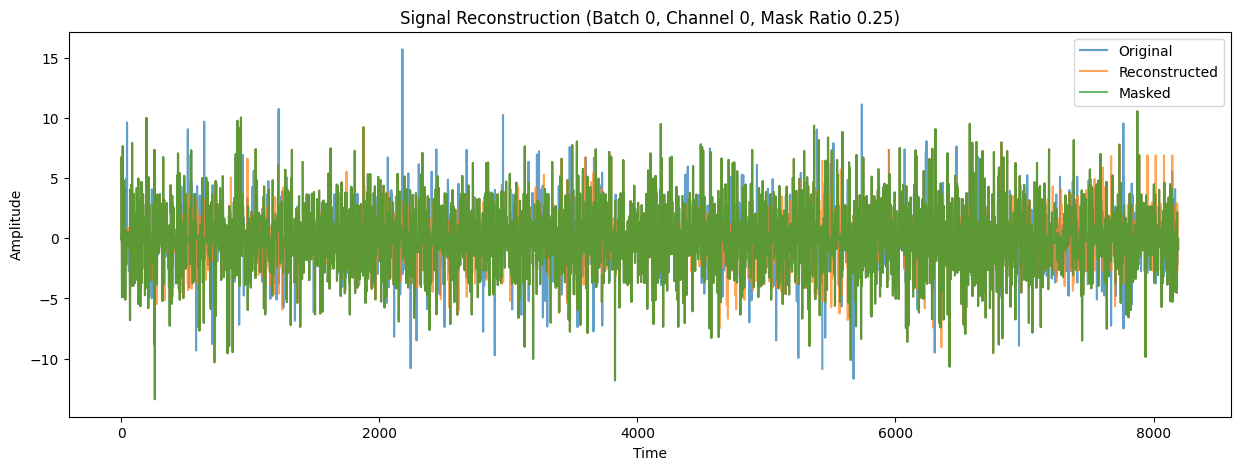

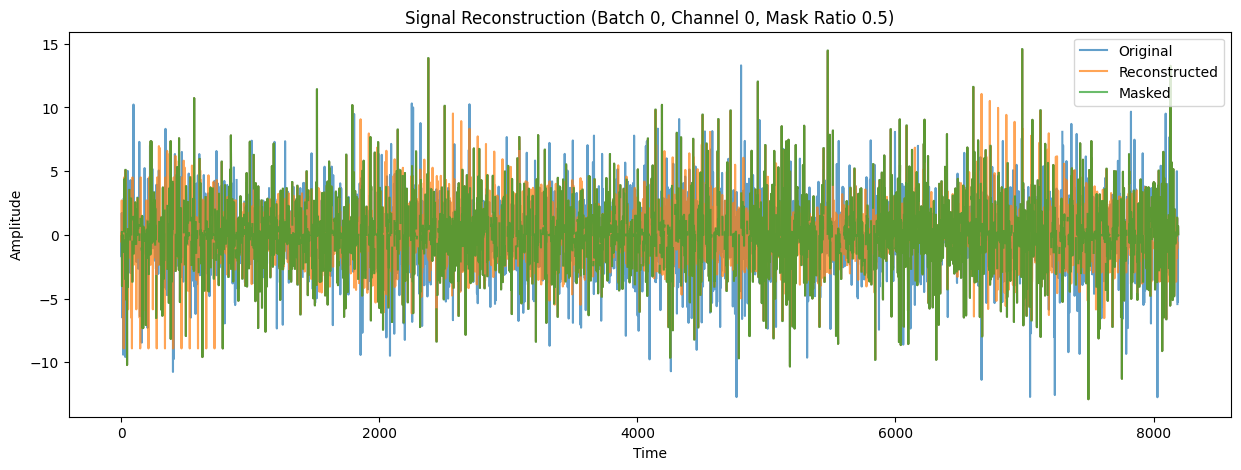

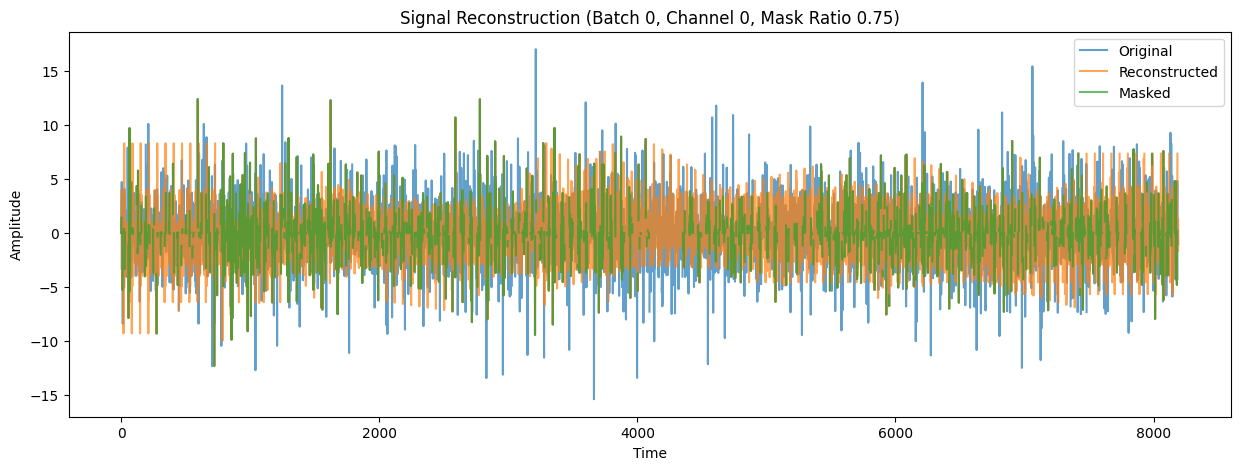

In [43]:
corrs = []
mses = []
ratios = [0.25, 0.5, 0.75]
for mask_ratio in ratios:
    results = evaluate_interpolation_baseline(train_dl, model, mask_ratio=mask_ratio)
    corrs.append(results[0])
    mses.append(results[1])

In [44]:
len(corrs[0][0]), len(corrs[1][0]), len(corrs[2][0])

(1577, 1577, 1577)

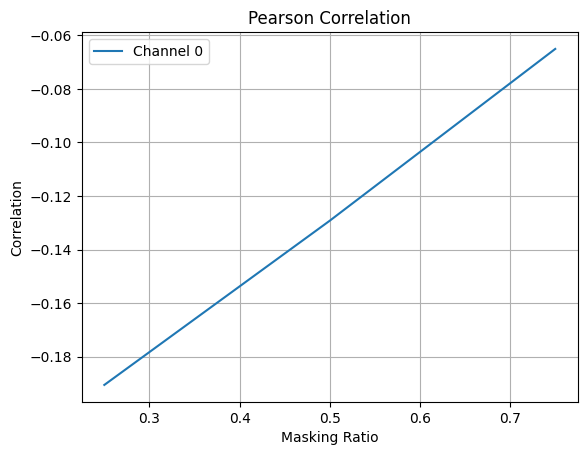

In [45]:
corrs_np = np.array(corrs)
ratio_corrs = np.nanmean(corrs_np, axis=2)
for i in range(ratio_corrs.shape[1]):
    plt.plot(ratios, ratio_corrs[:, i], label=f'Channel {i}')
plt.title('Pearson Correlation')
plt.xlabel('Masking Ratio')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.show()

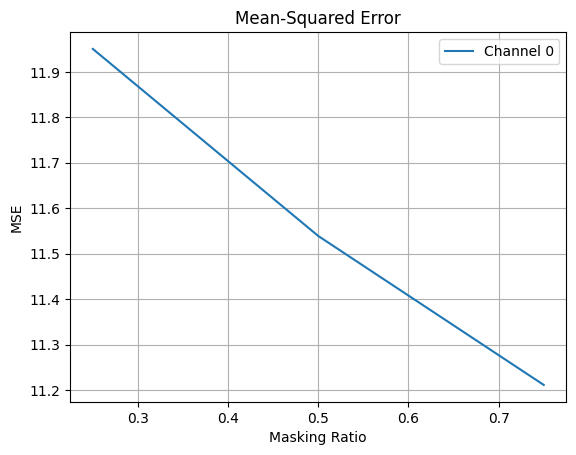

In [46]:
mse_np = np.array(mses)
ratio_mse = np.nanmean(mse_np, axis=2)
for i in range(ratio_mse.shape[1]):
    plt.plot(ratios, ratio_mse[:, i], label=f'Channel {i}')
plt.title('Mean-Squared Error')
plt.xlabel('Masking Ratio')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()

Interestingly we see that while the absolute value of the correlation decreases with a higher masking ratio (expected from worse performance), the mean squared error drops. One guess as to why this is would be that as the masking ratio increases our reconstruction would become increasingly flat as it jumps between fewer peaks which are usually masked. Let's see what we get if we reconstruct some batches using a flat line at 0.

In [48]:
all_mses = [[] for _ in range(len(experiment_config.ecog_data_config.bands))]

model = model.to("cpu")
model.eval()

for i, batch in enumerate(train_dl):
    if i > 10:
        break

    batch = batch.to("cpu")
    # Normalize batch like we do with model
    batch = model.forward_input_norm(batch)

    masked_input, batch_mask = get_masked_batch(model, batch)

    # Reconstruction is all 0's
    reconstructed = torch.zeros_like(masked_input)

    _, mses = evaluate_reconstruction(batch, reconstructed, batch_mask)
    # Add new metrics for each channel.
    for j in range(len(all_mses)):
        all_mses[j] = all_mses[j] + mses[j]
model = model.to(device)
model.train()

mses_np = np.array(all_mses)
np.nanmean(mses_np)

/var/folders/z7/qrc5k22j2qq05jzdksv8hd_00000gn/T/ipykernel_42746/4263209665.py:89: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(orig_masked.flatten(), recon_masked.flatten())


np.float32(6.143117)

Surprisingly we see that this actually works better than the linear interpolation! If you think about it more it's actually not super surprising. We normalize our inputs to have a mean 0 and standard deviation of 1 before passing it into our model, so if you just predict 0 you're always predicting the mean of the data and you'll do pretty well without learning anything. This has important implications for the model, because if you just use the mse loss the model will tend to predict 0 and reach a local optimum very quickly and not learn anything. This realization is what motivated the alpha term in our loss which is used to incentive the model to also care about the fluctuations in the data using the pearson correlation.

If you want to for fun you can try to come up with other ways of modelling this task that don't necessarily rely on deep learning. They won't necessarily result in low-dimensional embeddings that we can use downstream but will give you a better sense of the data and could maybe help with the modelling task. Some ideas:

1. Using neighboring electrodes that are not masked to fill in masked data and seeing how that performs.
2. Trying to incorporate simpler linear methods like PCA into a model and seeing if you can reconstruct the signal from that.
3. More complex interpolation functions beyond linear.
4. Anything else you can think of!